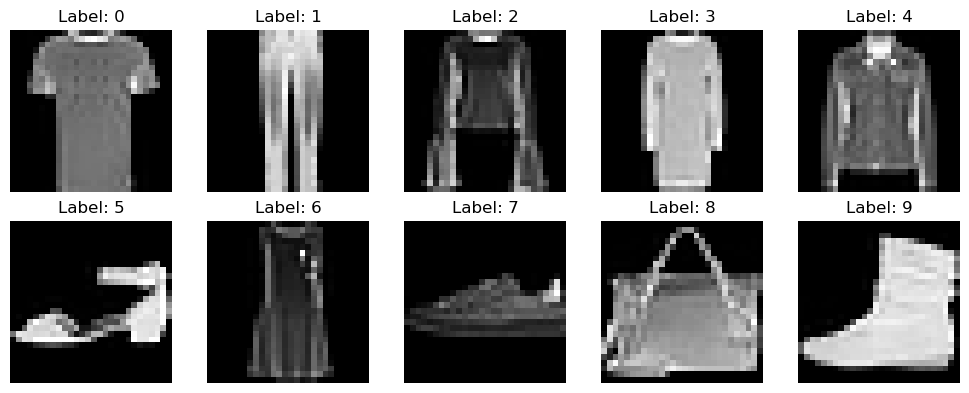

       label  pixel1  pixel2  pixel3  pixel4  pixel5  pixel6  pixel7  pixel8  \
0          6       0       0       0       0       0       0       0       0   
1          8       0       0       0       0       0       0       0       0   
2          9       0       0       0       0       0       0       0       0   
3          0       0       0       0       1       0       0       0       0   
4          0       0       0       0       0       0       1       0       0   
...      ...     ...     ...     ...     ...     ...     ...     ...     ...   
47995      2       0       0       0       0       0       0       0       0   
47996      9       0       0       0       0       0       0       0       0   
47997      7       0       0       0       0       0       0       0       0   
47998      0       0       0       0       0       0       0      17      99   
47999      3       0       0       0       0       0       0       0       0   

       pixel9  ...  pixel775  pixel776 

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np

from sklearn.preprocessing import OneHotEncoder


# Load the fixed CSV
df = pd.read_csv("fashion-mnist_train.csv")

# Group by class label
grouped = df.groupby("label")

# Prepare empty lists for train and test splits
train_list = []
test_list = []

# Split each class group into 80% train and 20% test
for label, group in grouped:
    train_split, test_split = train_test_split(
        group, 
        test_size=0.2, 
        random_state=42, 
        shuffle=True,
        stratify=None  # We are already splitting by class manually
    )
    train_list.append(train_split)
    test_list.append(test_split)

# Concatenate all class-wise splits
train_df = pd.concat(train_list).sample(frac=1, random_state=42).reset_index(drop=True)
test_df = pd.concat(test_list).sample(frac=1, random_state=42).reset_index(drop=True)


# One example per class
examples = train_df.groupby("label").first().reset_index()

# Plot
plt.figure(figsize=(10, 4))
for i in range(10):
    ax = plt.subplot(2, 5, i + 1)
    img = examples.loc[i].drop("label").values.astype(np.uint8).reshape(28, 28)
    plt.imshow(img, cmap="gray")
    plt.title(f"Label: {examples.loc[i, 'label']}")
    plt.axis("off")

plt.tight_layout()
plt.show()
print(train_df)
print(test_df)


Epoch 0: Loss = 1.3236, Train Acc = 63.55%, Test Acc = 63.20%
Epoch 10: Loss = 0.7007, Train Acc = 79.61%, Test Acc = 79.46%
Epoch 20: Loss = 0.5590, Train Acc = 82.20%, Test Acc = 81.88%
Epoch 30: Loss = 0.5166, Train Acc = 83.71%, Test Acc = 83.57%
Epoch 40: Loss = 0.4840, Train Acc = 84.71%, Test Acc = 84.37%
Epoch 50: Loss = 0.4335, Train Acc = 85.46%, Test Acc = 84.82%
Epoch 60: Loss = 0.3782, Train Acc = 86.10%, Test Acc = 85.17%
Epoch 70: Loss = 0.4846, Train Acc = 86.51%, Test Acc = 85.69%
Epoch 80: Loss = 0.3482, Train Acc = 87.06%, Test Acc = 86.22%
Epoch 90: Loss = 0.2995, Train Acc = 87.48%, Test Acc = 86.52%
Epoch 100: Loss = 0.3338, Train Acc = 87.71%, Test Acc = 86.53%
Epoch 110: Loss = 0.4519, Train Acc = 88.01%, Test Acc = 86.98%
Epoch 120: Loss = 0.2904, Train Acc = 88.23%, Test Acc = 87.16%
Epoch 130: Loss = 0.3940, Train Acc = 88.46%, Test Acc = 87.25%
Epoch 140: Loss = 0.3913, Train Acc = 88.60%, Test Acc = 87.34%
Epoch 150: Loss = 0.3081, Train Acc = 88.88%, Test 

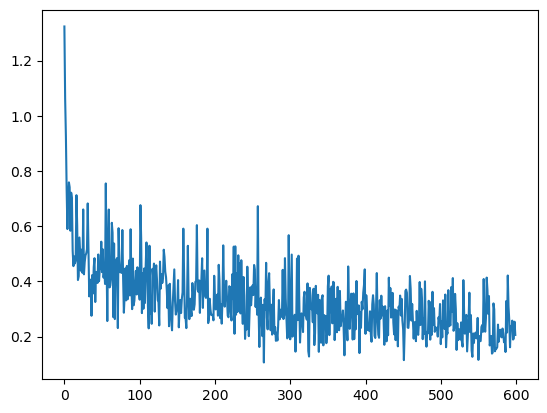

In [5]:
import numpy as np
import time
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
import random
from PIL import Image, ImageOps

np.random.seed(0)

def augment_image(img_array):
    img_array = img_array.reshape(28, 28)
    
    img = Image.fromarray(img_array)

    if random.random() > 0.5:
        img = ImageOps.mirror(img)  

    
    if random.random() > 0.5:
        img = img.rotate(random.choice(np.arange(-15,15+1))) 

    img = np.array(img)
    img = img.reshape(28 * 28)
    
    return img

def ReLU(x):
    return np.maximum(0, x)

def ReLU_D(x):
    return np.where(x > 0, 1, 0)

def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def sigmoid_D(a):
    return a * (1 - a)

def softmax(z):
    exp_z = np.exp(z - np.max(z, axis=1, keepdims=True))
    return exp_z / np.sum(exp_z, axis=1, keepdims=True)

# Normalize and encode labels
X_train = train_df.drop("label", axis=1).values / 255.0
y_train = train_df["label"].values.reshape(-1, 1)
X_test = test_df.drop("label", axis=1).values / 255.0
y_test = test_df["label"].values.reshape(-1, 1)

encoder = OneHotEncoder(sparse_output=False)
y_train_encoded = encoder.fit_transform(y_train)
y_test_encoded = encoder.transform(y_test)
np.random.seed(0)
mean = np.mean(X_train)
std = np.std(X_train)
X_train = (X_train - mean) / std
X_test = (X_test - mean) / std

layers = [X_train.shape[1], 128, 10]
activation = ['sigmoid','softmax']

def init_weights(layers):
    weights = {}
    biases = {}
    for i in range(1, len(layers)):
        if activation[i - 1] == "ReLU":
            weights[f"W{i}"] = np.random.randn(layers[i - 1], layers[i]) * np.sqrt(2 / layers[i - 1])
        elif activation[i - 1] == "sigmoid":
            weights[f"W{i}"] = np.random.randn(layers[i - 1], layers[i]) * np.sqrt(1 / layers[i - 1])
        else:
            weights[f"W{i}"] = np.random.randn(layers[i - 1], layers[i]) * 0.01
        biases[f"b{i}"] = np.zeros((1, layers[i]))
    return weights, biases

def forward_pass(X, weights, biases, activation):
    cache = {"A0": X}
    A = X
    for i in range(1, len(activation) + 1):
        Z = np.dot(A, weights[f"W{i}"]) + biases[f"b{i}"]
        if activation[i - 1] == "ReLU":
            A = ReLU(Z)
        elif activation[i - 1] == "sigmoid":
            A = sigmoid(Z)
        elif activation[i - 1] == "softmax":
            A = softmax(Z)
        cache[f"Z{i}"] = Z
        cache[f"A{i}"] = A
    return A, cache

def backward_pass(y_true, weights, cache, activation):
    grads = {}
    m = y_true.shape[0]
    L = len(activation)
    dZ = cache[f"A{L}"] - y_true

    for i in reversed(range(1, L + 1)):
        A_prev = cache[f"A{i - 1}"]
        grads[f"dW{i}"] = np.dot(A_prev.T, dZ) / m
        grads[f"db{i}"] = np.sum(dZ, axis=0, keepdims=True) / m
        if i > 1:
            dA_prev = np.dot(dZ, weights[f"W{i}"].T)
            if activation[i - 2] == "ReLU":
                dZ = dA_prev * ReLU_D(cache[f"Z{i - 1}"])
            elif activation[i - 2] == "sigmoid":
                dZ = dA_prev * sigmoid_D(cache[f"A{i - 1}"])
    return grads

def update_weights(weights, biases, grads, lr):
    for key in weights:
        weights[key] -= lr * grads[f"d{key}"]
    for key in biases:
        biases[key] -= lr * grads[f"d{key}"]
    return weights, biases

def accuracy(X, y, weights, biases, activation):
    y_pred, _ = forward_pass(X, weights, biases, activation)
    predictions = np.argmax(y_pred, axis=1)
    true_labels = np.argmax(y, axis=1)
    return np.mean(predictions == true_labels)

def train(X, y, layers, activation, epochs=600, lr=0.01, lemda=0.001, batch_size=64):
    weights, biases = init_weights(layers)
    loss_history = []
    m = X.shape[0]
    best_test_acc = 0
    best_weights = None
    best_biases = None
    

    for epoch in range(epochs):
        pack = np.random.permutation(m)
        X_shuffled = X[pack]
        y_shuffled = y[pack]

        for i in range(0, m, batch_size):
            X_batch = X_shuffled[i:i+batch_size]
            X_batch = np.array([augment_image(img) for img in X_batch])
            y_batch = y_shuffled[i:i+batch_size]
            b_size = X_batch.shape[0]

            y_pred, cache = forward_pass(X_batch, weights, biases, activation)
            L_loss = -np.sum(y_batch * np.log(y_pred + 1e-9)) / b_size
            reg = (lemda / (2 * b_size)) * sum(np.sum(weights[f"W{k}"] ** 2) for k in range(1, len(layers)))
            loss = L_loss + reg

            grads = backward_pass(y_batch, weights, cache, activation)
            for k in range(1, len(layers)):
                grads[f"dW{k}"] += (lemda / b_size) * weights[f"W{k}"]

            weights, biases = update_weights(weights, biases, grads, lr)

        loss_history.append(loss)

        if epoch % 10 == 0 or epoch == epochs - 1:
            train_acc = accuracy(X, y, weights, biases, activation)
            test_acc = accuracy(X_test, y_test_encoded, weights, biases, activation)
            print(f"Epoch {epoch}: Loss = {loss:.4f}, Train Acc = {train_acc*100:.2f}%, Test Acc = {test_acc*100:.2f}%")

        if test_acc > best_test_acc:
            best_test_acc = test_acc
            best_weights = {k: v.copy() for k, v in weights.items()}
            best_biases = {k: v.copy() for k, v in biases.items()}

    return weights, biases, loss_history, best_weights, best_biases

weights_trained, biases_trained, loss_history, best_weights, best_biases = train(X_train, y_train_encoded, layers, activation)

print("Final Train Accuracy:", round(accuracy(X_train, y_train_encoded, weights_trained, biases_trained, activation) * 100, 2), "%")
print("Final Test Accuracy:", round(accuracy(X_test, y_test_encoded, weights_trained, biases_trained, activation) * 100, 2), "%")

plt.plot(loss_history)


In [6]:
print("Best weights for layer 1:\n", weights_trained["W1"])
print("Best biases for layer 1:\n", biases_trained["b1"])


Best weights for layer 1:
 [[ 0.07243969  0.00942754  0.06515991 ... -0.03160386 -0.02506158
   0.11657596]
 [ 0.02272849  0.0151238  -0.00076309 ... -0.00018136 -0.0019886
   0.06959505]
 [-0.05095111 -0.07891642 -0.03265682 ...  0.04870615 -0.0891907
  -0.00746088]
 ...
 [ 0.04472341 -0.04097326 -0.01936615 ... -0.01090007  0.00387722
  -0.01491229]
 [ 0.02132736  0.05652038  0.00543829 ...  0.05501346  0.02877093
   0.04741826]
 [ 0.00266043  0.03368981  0.06671771 ... -0.04853641  0.02307327
   0.09310604]]
Best biases for layer 1:
 [[ 0.1909816   0.12733695  0.20438013  0.14875018  0.05796037 -0.18447705
   0.16076165 -0.09100177  0.15332507 -0.02750138 -0.16886528 -0.09730368
  -0.05694044  0.26504203 -0.15063923  0.13266337  0.0392726  -0.07751544
   0.1846868  -0.18569939 -0.25845531 -0.27489634  0.05411834  0.1101847
   0.06089417  0.11608499  0.10017674  0.19878611 -0.01612108 -0.23153704
   0.01762101  0.03207019  0.02016457 -0.07623688 -0.1250339  -0.10662115
  -0.07889913 

In [7]:

test_df = pd.read_csv("fashion-mnist_test.csv")
X_test = test_df.drop("label", axis=1).values / 255.0
y_test = test_df["label"].values.reshape(-1, 1)

X_test = (X_test - mean) / std

y_test_encoded = encoder.transform(y_test)

f_output, _ = forward_pass(X_test, weights_trained, biases_trained, activation)

f_acc = accuracy(X_test, y_test_encoded, weights_trained, biases_trained, activation)
print(f"Final Accuracy : {f_acc * 100:.2f}%")
print("Final Cost :", loss_history[-1])


Final Accuracy : 89.55%
Final Cost : 0.20597480828192138
